# Kaggle Product Failure  
By Joshua Mayes - 08/18/2022

In [1]:
# Core DS libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

import mytk # My Toolkit
import wrangle # Helper functions

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier


In [3]:
pd.options.display.max_columns = None
train, test, validate = wrangle.wrangle_potatoes()

In [4]:
# Load and impute null values for the kaggle submission data
final = pd.read_csv('./data/test.csv')
imputeCols = train.select_dtypes(include=np.number).drop(columns='failure').columns.tolist()
imputer =  SimpleImputer()
imputer.fit(train[imputeCols])
final[imputeCols] = imputer.transform(final[imputeCols])

## Findings

### The failure rate varies slightly across different product codes.

<AxesSubplot:xlabel='product_code', ylabel='failure'>

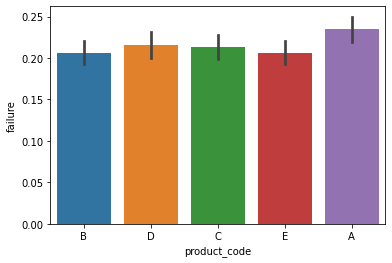

In [5]:
# Show the failure rate across product codes
sns.barplot(data=train, x='product_code', y='failure')

In all of my exploration this seemed to be the single most powerful predictor of failure.  
However, the product codes don't match the dataset we will be predicting on

In [6]:
# Show the product codes available in the final dataset
final.product_code.value_counts()

F    5422
I    5228
G    5107
H    5018
Name: product_code, dtype: int64

So we cannot use that as a predictor.

### When examining each product separately, measurement_2 is the only feature that has predictive power over failure.

In [7]:
# Use my toolkit to quickly identify category columns stored as integers
gotchas = mytk.get_gotchas(train)
override_cat = gotchas['probable_categories']

# Function that splits the data by product code and deploys statistical tests
def failure_stats_for_each_prod(df):
    prod = {}
    for code in df.product_code.unique().tolist():
        prod[code] =  df[df.product_code == code].copy()
    results = {}
    for k, v in prod.items():
        results[k] = mytk.pop_unrejected(mytk.all_the_stats(v, override_categorical=override_cat))['failure']
    # Then prints it in json format
    print(mytk.prettify(results))

failure_stats_for_each_prod(train)

{
  "B": {
    "chi2": {},
    "anova": {
      "loading": {
        "reject": "true",
        "h0": "There is no variance in loading between subsets of failure",
        "stat_name": "F",
        "stat": 63.75113348764017,
        "p_value": 1.9485223729267693e-15,
        "alpha": 0.05,
        "ttest": {
          "0.0": {
            "reject": "true",
            "h0": "The mean of loading for failure:0.0 is the same as the overall population",
            "stat_name": "F",
            "stat": -3.7484029332823434,
            "p_value": 0.0001819219783207693,
            "alpha": 0.05
          },
          "1.0": {
            "reject": "true",
            "h0": "The mean of loading for failure:1.0 is the same as the overall population",
            "stat_name": "F",
            "stat": 6.379576970606541,
            "p_value": 3.3360108932600885e-10,
            "alpha": 0.05
          }
        }
      },
      "measurement_1": {
        "reject": "true",
        "h0": "There is

For products "B" and "D" `measurement_2` seems to be a statistically significant predictor of failure.

### RFE (Recursive Feature Elimination) reveals some other strong predictors

Before I can use RFE, however, I need to temporarily encode my categorical variables

In [8]:
def encode_variables(df):
    catCols = ['product_code','attribute_0','attribute_1','attribute_2','attribute_3']
    for col in catCols:
        df[col] = df[col].astype('category').cat.codes
    return df
# Encode categoricals
train_encoded = encode_variables(train)

In [9]:
estimator = RandomForestClassifier(max_depth=5)
selector = RFE(estimator=estimator, n_features_to_select=3 )
selector.fit(train_encoded.drop(columns='failure'), train_encoded.failure)
selector.get_feature_names_out()

array(['loading', 'measurement_5', 'measurement_17'], dtype=object)

In [10]:
feats = ['loading', 'measurement_2','measurement_3', 'measurement_16' ] 
target = 'failure'